In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
from skimage.util import montage
from fastai.callbacks.hooks import num_features_model
from torch.nn import L1Loss
import pandas as pd
from torch import optim
import re
import json
import cv2
import types

from utils import *

In [2]:
j = json.load(open('data/annotations.json'))
{a['class']: [a['y'], a['x']] for a in j[0]['annotations'] if a['class'] != 'fluke'}

{'left': [98.58659021176, 50.802273527488566],
 'notch': [269.48861474128864, 516.2391276137811],
 'right': [102.10753986218477, 1013.5305065138045]}

In [3]:
SZ = 224
BS = 64
NUM_WORKERS = 12

In [4]:
def anno2points(anno):
    im_width, im_height = PIL.Image.open(f"data/train/{anno['filename']}").size
    points_dict = {a['class']: [a['y'] if a['y'] <= im_height else im_height, a['x']  if a['x'] <= im_width else im_width] for a in anno['annotations'] if a['class'] != 'fluke'}
    points = tensor([points_dict['left'], points_dict['notch'], points_dict['right']])
    points[:, 0] *= 224 / im_height
    points[:, 1] *= 224 / im_width 
    return points

In [5]:
anno2points(j[0])

tensor([[ 36.8057,  10.8378],
        [100.6091, 110.1310],
        [ 38.1201, 216.2198]])

In [6]:
fn2anno = {jj['filename']: anno2points(jj) for jj in j}
path2fn = lambda path: re.search('\w*\.jpg$', path).group(0)
get_y_func = lambda o: fn2anno[path2fn(o)]

In [7]:
val_fns = pd.read_pickle('data/val_fns_detection.pkl') # I create this file in fluke_detection.ipynb

In [8]:
data = (PointsItemList.from_df(pd.DataFrame(data=list(fn2anno.keys())), path='data/train-224')
        .split_by_valid_func(lambda path: path2fn(path) in val_fns)
        .label_from_func(get_y_func)
        .transform(None, tfm_y=True, size=(SZ,SZ), resize_method=ResizeMethod.SQUISH)
        .databunch().normalize(imagenet_stats)
       )

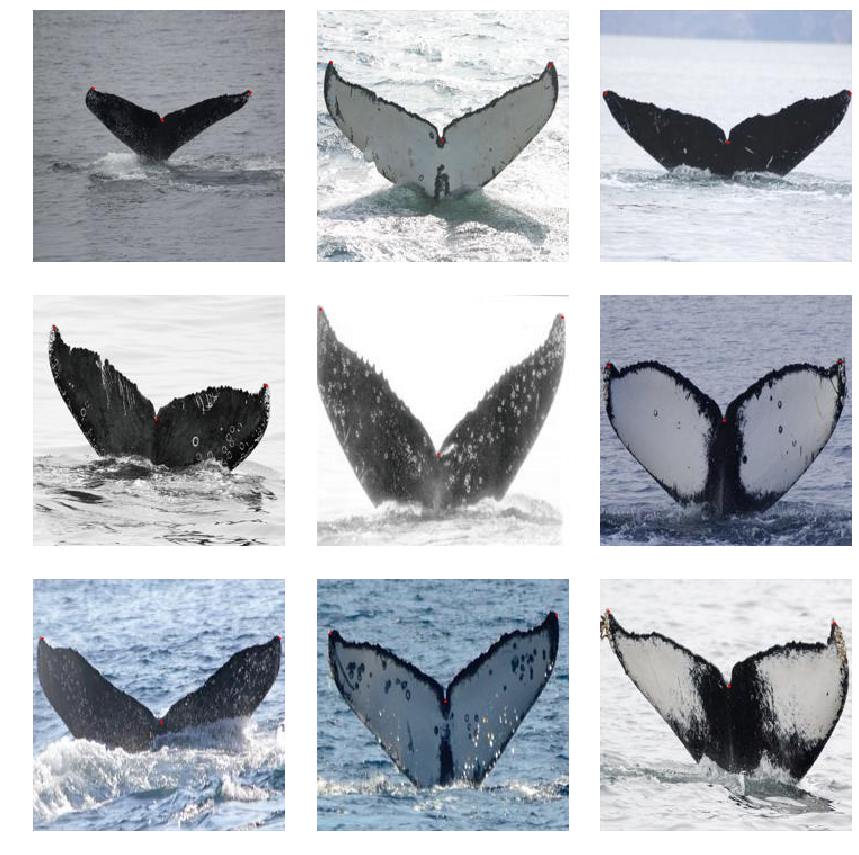

In [22]:
data.show_batch(3, figsize=(12,12), ds_type=DatasetType.Train)

In [10]:
class LandmarkDetector(nn.Module):
    def __init__(self, arch=models.resnet18, points_count=3):
        super().__init__()
        self.points_count = points_count
        self.cnn = create_body(arch)
        self.head = create_head(num_features_model(self.cnn) * 2, points_count * 2)
        
    def forward(self, im):
        bs = im.shape[0]
        
        x = self.cnn(im)
        x = self.head(x)
        
        activations = 2 * (x.sigmoid_() - 0.5)
        return activations.reshape(bs, self.points_count, 2)

In [11]:
def loss_fn(preds, targs): return L1Loss()(preds, targs)

In [12]:
learn = Learner(data, LandmarkDetector(arch=models.resnet50), loss_func=loss_fn)

In [13]:
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.head])

In [14]:
learn.freeze_to(-1)

In [15]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss
1,0.557639,0.569242
2,0.553571,0.602398
3,0.524365,0.670541
4,0.458350,0.351188
5,0.389018,0.213914
6,0.340711,0.171246
7,0.304485,0.133429
8,0.275737,0.119055
9,0.252823,0.110069
10,0.233584,0.109376


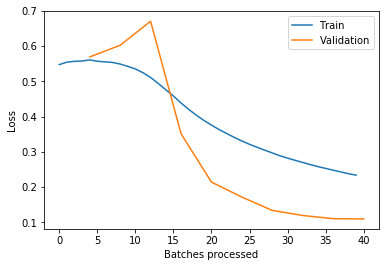

In [16]:
learn.recorder.plot_losses()

In [17]:
learn.unfreeze()

In [18]:
max_lr = 2e-3
lrs = [max_lr/100, max_lr/10, max_lr]

In [19]:
learn.fit_one_cycle(40, lrs)

epoch,train_loss,valid_loss
1,0.116761,0.108092
2,0.113090,0.107341
3,0.110349,0.106516
4,0.109316,0.105253
5,0.107605,0.102958
6,0.104942,0.099436
7,0.103871,0.099996
8,0.101973,0.094462
9,0.099733,0.091798
10,0.098279,0.088003


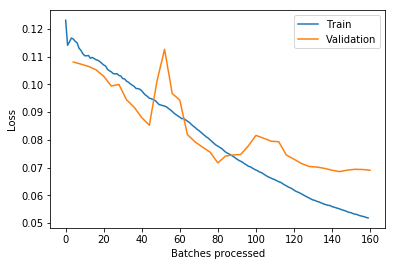

In [20]:
learn.recorder.plot_losses()

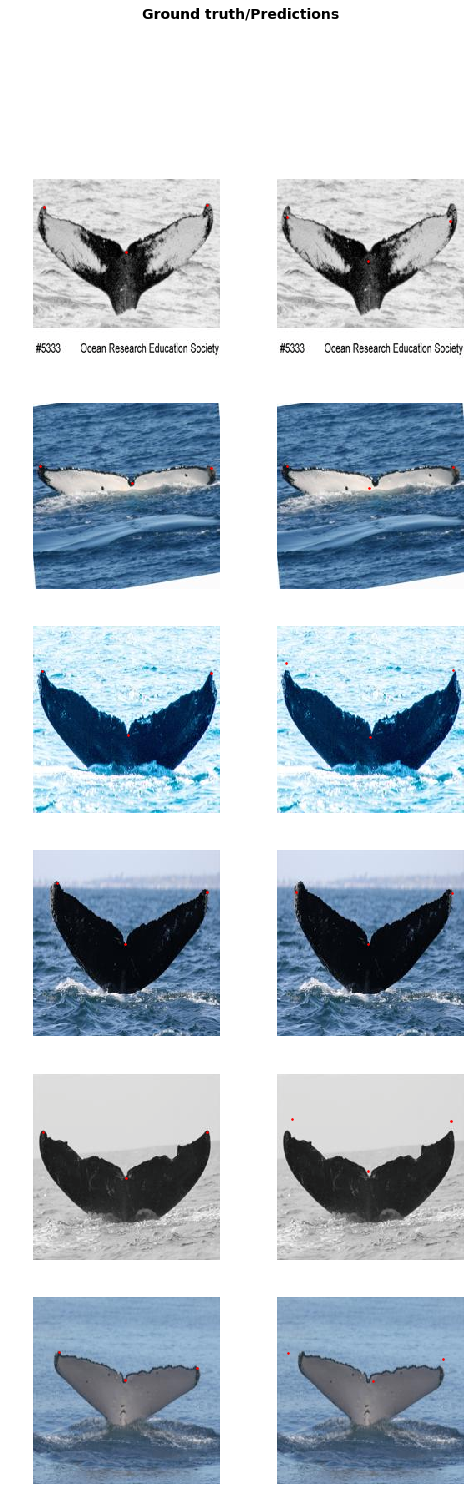

In [21]:
learn.show_results(rows=6)